### Importing GT

In [1]:
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
from compas.geometry import oriented_bounding_box_numpy
from pytorch3d.ops import box3d_overlap
import torch
import os
import open3d as o3d
import matplotlib.pyplot as plt
import sys
import torch
from torch import nn
from copy import deepcopy

sys.path.append('box_estimation/Pointnet_Pointnet2_pytorch')
sys.path.append('box_estimation/Pointnet_Pointnet2_pytorch/models')

In [2]:
labels_foler = "../labelCloud/labels"
filenames = os.listdir(labels_foler)
filenames = [f for f in filenames if "_classes" not in f and f.endswith(".json")]
for file in filenames:
    j = json.load(open(labels_foler + "/" + file))
    for object in j["objects"]:
        object['rotations']['x'] = 0
        object['rotations']['y'] = 0

    json.dump(j, open(labels_foler + "/" + file, "w"))

In [3]:
def sincos_to_angle(sin_val, cos_val):
    angle = torch.atan2(sin_val, cos_val)  # Get the angle in radians
    angle = angle % (2 * np.pi)  # Ensure the angle is in the range [0, 2*pi)
    angle = angle / (2 * np.pi)  # Scale to [0, 1]
    return angle.numpy()

def angles_to_sincos(angles):
    sin_angles = torch.sin(angles * 2 * np.pi)  # Assuming angles are scaled between 0 and 1
    cos_angles = torch.cos(angles * 2 * np.pi)
    return np.array([sin_angles.numpy(), cos_angles.numpy()])

def normalize_point_cloud(point_cloud):
    """
    Normalize the point cloud and the relative oriented bounding box (OBB).
    
    Parameters:
    point_cloud (np.ndarray): The point cloud as an array of shape (N, 3).
    obb_vertices (np.ndarray): OBB is centroid, dimensions, and rotations. (3, 3, 3)
    
    Returns:
    np.ndarray: The normalized point cloud.
    np.ndarray: The normalized OBB, rotations are scaled between 0 and 1
    """
    # Calculate the centroid of the point cloud
    centroid = np.mean(point_cloud, axis=0)
    
    centered_pc = point_cloud - centroid

    # Calculate the maximum distance from the origin for the point cloud points
    max_distance = np.max(np.linalg.norm(centered_pc, axis=1))
    
    # Scale point cloud points
    scaled_pc = centered_pc / max_distance

    
    return scaled_pc, max_distance, centroid

def denormalize_obb(normalized_obb, max_distance, original_centroid):
    """
    Denormalize the point cloud and the relative oriented bounding box (OBB).
    
    Parameters:
    normalized_pc (np.ndarray): The normalized point cloud as an array of shape (N, 3).
    normalized_obb (np.ndarray): The normalized OBB, rotations are scaled between 0 and 1.
    max_distance (float): The maximum distance used for normalization.
    original_centroid (np.ndarray): The original centroid of the point cloud.
    
    Returns:
    np.ndarray: The denormalized point cloud.
    np.ndarray: The denormalized OBB.
    """
    # Extract normalized OBB components
    normalized_obb_centroid = deepcopy(normalized_obb[:3])
    normalized_obb_dimensions = deepcopy(normalized_obb[3:6])
    
    sin_cos_rx = torch.tensor(deepcopy(normalized_obb[6:8]))
    sin_cos_ry = torch.tensor(deepcopy(normalized_obb[8:10]))
    sin_cos_rz = torch.tensor(deepcopy(normalized_obb[10:12]))
    
    # Convert sin and cos back to angles
    denorm_rx = sincos_to_angle(sin_cos_rx[0], sin_cos_rx[1])
    denorm_ry = sincos_to_angle(sin_cos_ry[0], sin_cos_ry[1])
    denorm_rz = sincos_to_angle(sin_cos_rz[0], sin_cos_rz[1])
    
    denorm_rotations = np.array([denorm_rx, denorm_ry, denorm_rz]) * 360
    
    # Denormalize the point cloud and OBB components
    denorm_obb_centroid = normalized_obb_centroid * max_distance + original_centroid
    denorm_obb_dimensions = normalized_obb_dimensions * max_distance
    
    denorm_obb = np.concatenate([denorm_obb_centroid, denorm_obb_dimensions, denorm_rotations])
    
    return denorm_obb

In [4]:
from box_estimation.Pointnet_Pointnet2_pytorch.models.pointnet_utils import PointNetEncoder
class PointCloudNet(nn.Module):
    def __init__(self):
        super(PointCloudNet, self).__init__()
        self.backbone = PointNetEncoder(global_feat=True, feature_transform=False, channel = 3)
        self.fc = nn.Sequential(
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 8)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = x[0]
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        x = x.view(-1, 1, 8)
        return x

    def train_model(self, num_epochs, optimizer, criterion, train_loader, test_loader, device):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, data in enumerate(tqdm(train_loader)):
                points, box, _, _ = data                
                points, box = points.to(device), box.to(device)
                optimizer.zero_grad()
                outputs = model(points)
                loss = criterion(outputs, box)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            print(f"Epoch {epoch} - Loss: {running_loss / len(train_loader)}")

            model.eval()
            running_loss = 0.0
            for i, data in enumerate(tqdm(test_loader)):
                points, box, _, _ = data
                points, box = points.to(device), box.to(device)
                outputs = model(points)
                loss = criterion(outputs, box)
                running_loss += loss.item()
            
            if running_loss < best_val_loss:
                best_val_loss = running_loss
                torch.save(model.state_dict(), "pc_net.pth")
            print(f"Validation Loss: {running_loss / len(test_loader)}")

device = torch.device("mps")
model = PointCloudNet()
model.to(device)
model.train()
x = torch.randn(10, 3, 120, device = device)
model(x).shape


torch.Size([10, 1, 8])

In [5]:
IOU_THRESHOLD = .0
LABEL_FOLDER = "labels/"

gt_jsons = [f for f in os.listdir(LABEL_FOLDER) if f.endswith('.json') and "gt" in f]
pred_jsons = [f for f in os.listdir(LABEL_FOLDER) if f.endswith('.json') and "pred" in f]
gt_jsons.sort(), pred_jsons.sort()
gt_jsons = [file for file in gt_jsons if "515" not in file]
pred_jsons = [file for file in pred_jsons if "515" not in file]
gt_jsons, pred_jsons

(['1_cropped_gt.json',
  '2_cropped_gt.json',
  '3_gt.json',
  '5_gt.json',
  '6_gt.json',
  '7_gt.json'],
 ['1_cropped_pred.json',
  '2_cropped_pred.json',
  '3_pred.json',
  '5_pred.json',
  '6_pred.json',
  '7_pred.json'])

In [6]:
def compute_3d_IoU(box1, box2):
    box1 = torch.tensor(box1, dtype=torch.float32).unsqueeze(0)
    box2 = torch.tensor(box2, dtype=torch.float32).unsqueeze(0)
    vol, IoU =  box3d_overlap(box1, box2)

    return IoU.item()

In [7]:
points_unit = [
        [0.9, 0.9, 0.9],
        [0, 0, 0],
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 1],
    ]
box = oriented_bounding_box_numpy(np.array(points_unit))
box

[[0.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0]]

In [8]:
def reorder_vertices(box):
    """
    A unit cube, defined with the pythorch3d convention, has the following vertices:
        [0, 0, 0],                    (4) +---------+. (5)
        [1, 0, 0],                        | ` .     |  ` .
        [1, 1, 0],                        | (0) +---+-----+ (1)
        [0, 1, 0],                        |     |   |     |
        [0, 0, 1],                    (7) +-----+---+. (6)|
        [1, 0, 1],                        ` .   |     ` . |
        [1, 1, 1],                        (3) ` +---------+ (2)
        [0, 1, 1],
    
    While the OrientedBoundingBox from Open3D has the following vertices:
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 1, 1],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]

    This function reorders the vertices of the OrientedBoundingBox to match the pytorch3d convention.
    This allows to use the official IoU function from Pytorch3D.
    """
    assert box.shape == (8, 3)

    reordered = [
        box[0], box[1], box[7], box[2],
        box[3], box[6], box[4], box[5]
    ]
    return np.array(reordered)

In [9]:
def create_obb_from_description(centroid, dimensions, rotations):
    # Extract centroid, dimensions, and rotations
    cx, cy, cz = centroid["x"], centroid["y"], centroid["z"]
    length, width, height = dimensions["length"], dimensions["width"], dimensions["height"]
    rx, ry, rz = rotations["x"], rotations["y"], rotations["z"]

    # Create the 8 corners of the box before rotation and translation
    dx = length / 2
    dy = width / 2
    dz = height / 2

    corners = np.array([
        [-dx, -dy, -dz],
        [ dx, -dy, -dz],
        [ dx,  dy, -dz],
        [-dx,  dy, -dz],
        [-dx, -dy,  dz],
        [ dx, -dy,  dz],
        [ dx,  dy,  dz],
        [-dx,  dy,  dz]
    ])

    # Apply rotations
    rotation = R.from_euler('xyz', [rx, ry, rz], degrees=True)
    rotated_corners = rotation.apply(corners)

    # Apply translation (centroid)
    translated_corners = rotated_corners + np.array([cx, cy, cz])

    return translated_corners

In [10]:
def get_box(model, points,  device):
    device = torch.device(device)
    model = model.to(device)
    points, max_distance, centroid = normalize_point_cloud(points)
    points = torch.tensor(points, dtype = torch.float32)
    if points.shape[0] > 1024:
        points = points[torch.randperm(points.shape[0])[:1024]]
    if points.shape[0] < 1024:
        points = torch.cat([points, torch.zeros(1024 - len(points), 3)])
    assert points.shape[0] == 1024
        
    points = points.permute(1, 0)
    points = points.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        box = model(points.to(device)).detach().cpu().squeeze(0)
        fake_rot = torch.tensor([[0.0, 1.0]])
        box = torch.cat([box[:, :6], fake_rot, fake_rot, box[:, 6:]], dim = 1).squeeze(0).numpy()
        box = denormalize_obb(box, max_distance, centroid)
        box_centroid = box[:3]
        box_dimensions = box[3:6]
        box_rotations = box[6:]
        box = create_obb_from_description(
            {"x": box_centroid[0], "y": box_centroid[1], "z": box_centroid[2]},
            {"length": box_dimensions[0], "width": box_dimensions[1], "height": box_dimensions[2]},
            {"x": box_rotations[0], "y": box_rotations[1], "z": box_rotations[2]}
        )
        return box

In [11]:
def get_z_aligned_box(pcd):
        temp = deepcopy(pcd)

        points = np.asarray(temp.points)

        mean = np.mean(np.asarray(points), axis=0)

        # Compute PCA on the XY components only
        xy_points = np.asarray(points)[:, :2] - mean[:2]
        cov_matrix = np.dot(xy_points.T, xy_points) / len(xy_points)
        eigvals, eigvecs = np.linalg.eig(cov_matrix)

        # Align primary component with the X-axis
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
        R = temp.get_rotation_matrix_from_xyz((0, 0, -angle))
        temp.rotate(R, center=mean)

        # Compute the axis-aligned bounding box of the rotated point cloud
        aabb = temp.get_axis_aligned_bounding_box()
        # convert aabb to oriented bbox
        aabb = o3d.geometry.OrientedBoundingBox.create_from_axis_aligned_bounding_box(
            aabb
        )

        # Apply inverse rotation to the bounding box
        aabb.rotate(R.T, center=mean)

        return np.asarray(aabb.get_box_points())

In [12]:
class Obj:
    def __init__(self, label, bbox):
        assert isinstance(label, str)
        assert isinstance(bbox, o3d.geometry.OrientedBoundingBox)
        self.label = label
        self.bbox = reorder_vertices(np.asarray(bbox.get_box_points()))

class Gt_Obj(Obj):
    def __init__(self, label, bbox, box_feat, map_pcd):
        super().__init__(label, bbox)
        cropped_pcd = map_pcd.crop(self.OBB())
        self.points = np.asarray(cropped_pcd.points)
        self.centroid = np.mean(bbox.get_box_points(), axis=0)
        self.box_feat = box_feat
        map_pcd = map_pcd.crop(self.OBB())
        self.bbox = reorder_vertices(np.asarray(self.OBB().get_box_points()))
    def OBB(self):
        box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(self.bbox))
        box.color = [0, 1, 0]
        return box

class Pred_Obj(Obj):
    def __init__(self, id, label, bbox, points, score):
        super().__init__(label, bbox)
        self.points = self.clean_points(points)
        self.centroid = np.mean(points, axis=0)
        self.id = id
        self.score = score
        #self.bbox = oriented_bounding_box_numpy(self.points)
        #self.bbox = get_box(model, self.points, "mps")
        self.bbox = get_z_aligned_box(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(self.points)))
        self.bbox = reorder_vertices(np.asarray(self.OBB().get_box_points()))

    def OBB(self):
        box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(self.bbox))
        box.color = [1, 0, 0]
        return box
    def clean_points(self, points):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.estimate_normals()
        clean, _ = pcd.remove_statistical_outlier(nb_neighbors=100, std_ratio=.5)
        return np.asarray(clean.points)

class ObjList:
    def __init__(self, objects: list):
        assert isinstance(objects, list)
        assert all(isinstance(obj, Obj) for obj in objects)
        self.objects = objects

    def __getitem__(self, key):
        return self.objects[key]

    def __len__(self):
        return len(self.objects)

    def get_boxes_list(self):
        return [obj.bbox for obj in self.objects]

In [13]:
model = PointCloudNet()
model.load_state_dict(torch.load("box_estimation/pc_net.pth"))

def load_gt(gt_json):
    gt_objects = []
    map_pcd = o3d.io.read_point_cloud("../labelCloud/" + gt_json["path"])
    for obj in gt_json["objects"]:
        box = create_obb_from_description(
            obj["centroid"], obj["dimensions"], obj["rotations"]
        ).tolist()
        centroid = list(obj["centroid"].values())
        dimensions = list(obj["dimensions"].values())
        rotations = list(obj["rotations"].values())
        box_feat = np.concatenate([centroid, dimensions, rotations])
        bbox = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(box))
        gt_objects.append(Gt_Obj(obj["name"], bbox, box_feat, map_pcd))

    return ObjList(gt_objects)


def load_pred(pred_json):
    predicted_objects = pred_json["objects"]
    for obj in predicted_objects:
        obj["bbox"] = np.array(obj["OBB"]).reshape(8, 3)
        obj["points"] = np.array(obj["points"]).reshape(-1, 3)
        obj["minimum_bbox"] = oriented_bounding_box_numpy(obj["points"])

    # Load predicted bboxes
    pred_objects = []
    for obj in predicted_objects:
        bbox = np.array(obj["minimum_bbox"]).reshape(8, 3)
        v = o3d.utility.Vector3dVector(bbox)
        if np.sum(bbox) == 0:
            continue
        try:
            bbox = o3d.geometry.OrientedBoundingBox.create_from_points(v)
            pred_objects.append(Pred_Obj(obj["id"], obj["label"], bbox, obj["points"], obj["score"]))
        except Exception as e:
            print(e)

    return ObjList(pred_objects)


def load_data(gt_jsons, pred_jsons):
    DATA = {}
    gt_jsons.sort(), pred_jsons.sort()


    for i, (gt_json, pred_json) in enumerate(zip(gt_jsons, pred_jsons)):
        pc_path = json.load(open(LABEL_FOLDER + gt_json))["path"]
        pointCloud = o3d.io.read_point_cloud("../labelCloud/" + pc_path)
        gt_objects = load_gt(json.load(open(LABEL_FOLDER + gt_json)))
        pred_objects = load_pred(json.load(open(LABEL_FOLDER + pred_json)))
        DATA[i] = {
            "pointcloud": pointCloud,
            "gt": gt_objects,
            "pred": pred_objects,
        }

    return DATA


DATA = load_data(gt_jsons, pred_jsons)

In [14]:
idx = 0
label2idx = {}
for scene in DATA:
    gt_objects = DATA[scene]["gt"].objects
    pred_objects = DATA[scene]["pred"].objects
    for obj in gt_objects:
        if obj.label not in label2idx:
            label2idx[obj.label] = idx
            idx += 1

    for obj in pred_objects:
        if obj.label not in label2idx:
            label2idx[obj.label] = idx
            idx += 1

id2label = {v: k for k, v in label2idx.items()}
label2idx, id2label

({'tv': 0,
  'backpack': 1,
  'handbag': 2,
  'chair': 3,
  'laptop': 4,
  'bottle': 5,
  'person': 6,
  'dining table': 7,
  'mouse': 8,
  'couch': 9,
  'keyboard': 10,
  'scissors': 11,
  'clock': 12,
  'mug': 13,
  'cup': 14,
  'toilet': 15,
  'refrigerator': 16},
 {0: 'tv',
  1: 'backpack',
  2: 'handbag',
  3: 'chair',
  4: 'laptop',
  5: 'bottle',
  6: 'person',
  7: 'dining table',
  8: 'mouse',
  9: 'couch',
  10: 'keyboard',
  11: 'scissors',
  12: 'clock',
  13: 'mug',
  14: 'cup',
  15: 'toilet',
  16: 'refrigerator'})

In [15]:
def custom_draw_geometry(pcd, gt_objects, pred_objects):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)

    for obj in gt_objects:
        vis.add_geometry(obj.OBB())

    for obj in pred_objects:
        vis.add_geometry(obj.OBB())

    vis.run()
    vis.destroy_window()

In [16]:
#custom_draw_geometry(*DATA[3].values())

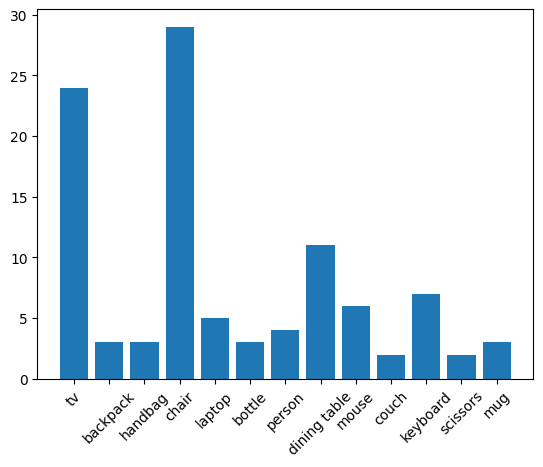

Total number of objects: 102


In [17]:
from collections import Counter

objects_counter = Counter()

for scene in DATA:
    for gt in DATA[scene]['gt']:
        objects_counter[gt.label] += 1

objects_counter
        
plt.bar(objects_counter.keys(), objects_counter.values())
plt.xticks(rotation=45)
plt.show()
print(f"Total number of objects: {sum(objects_counter.values())}")

In [18]:
import matplotlib.pyplot as plt


# Associating GT and predicted objects
def compute_3d_iou_matrix(gt_boxes, pred_boxes):
    """
    Compute the 3D IoU matrix between GT and predicted objects.

    Parameters:
    - gt_boxes: list of GT OrientedBoundingBox objects.
    - pred_boxes: list of predicted OrientedBoundingBox objects.

    Returns:
    - numpy array: 2D array where element (i, j) is the IoU between GT object i and predicted object j.
    """
    iou_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            try:
                iou = compute_3d_IoU(gt_box, pred_box)
            except Exception as e:
                iou = 0
            iou_matrix[i, j] = iou
    return iou_matrix


def get_matches(gt_objects, pred_objects, iou_threshold=0.5):
    """
    Get the matched GT and predicted objects.
    returns:
     - matched_couples: list of dictionaries containing the matched GT and predicted objects and their IoU.
     - phantom_predictions: list of predicted objects that have no match.
     - missed_gt: list of GT objects that have no match.
    """

    gt_boxes = gt_objects.get_boxes_list()
    pred_boxes = pred_objects.get_boxes_list()
    iou_matrix = compute_3d_iou_matrix(gt_boxes, pred_boxes)

    matches = []
    for i, j in zip(*np.where(iou_matrix > iou_threshold)):
        matches.append({"gt": i, "pred": j, "iou": iou_matrix[i, j]})
    matches = sorted(matches, key=lambda x: x["iou"], reverse=True)

    matched_gt = set()
    matched_preds = set()
    matched_couples = []
    for match in matches:
        if match["gt"] not in matched_gt and match["pred"] not in matched_preds:
            matched_gt.add(match["gt"])
            matched_preds.add(match["pred"])
            matched_couples.append(
                {
                    "gt": gt_objects[match["gt"]],
                    "pred": pred_objects[match["pred"]],
                    "iou": match["iou"],
                }
            )

    phantom_preds = [
        pred_objects[i] for i in range(len(pred_objects)) if i not in matched_preds
    ]
    missed_gt = [gt_objects[i] for i in range(len(gt_objects)) if i not in matched_gt]

    ious = [match["iou"] for match in matched_couples]
    assert len(ious) == len(set(ious))
    assert len(matched_couples) + len(phantom_preds) == len(pred_objects)
    assert len(matched_couples) + len(missed_gt) == len(gt_objects)

    return matched_couples, phantom_preds, missed_gt

matching_dict, phantom_preds_dict, missed_gt_dict = {}, {}, {}
for scene in DATA:
    gt_objects = DATA[scene]["gt"]
    pred_objects = DATA[scene]["pred"]
    matching_dict[scene], phantom_preds_dict[scene], missed_gt_dict[scene] = get_matches(gt_objects, pred_objects, IOU_THRESHOLD)

In [19]:
scene = 1
print("GT objects that have no match: ", len(missed_gt_dict[scene]))
print("Predicted objects that have no match: ", len(phantom_preds_dict[scene]))
#custom_draw_geometry(DATA[scene]["pointcloud"], missed_gt_dict[scene], phantom_preds_dict[scene])

GT objects that have no match:  0
Predicted objects that have no match:  2


In [20]:
matching, phantom_preds, missed_gt = [], [], []
for scene in DATA:
    matching.extend(matching_dict[scene])
    phantom_preds.extend(phantom_preds_dict[scene])
    missed_gt.extend(missed_gt_dict[scene])

In [21]:
np.mean([match["iou"] for match in matching])

0.4058866475069737

In [22]:
len(matching), len(phantom_preds), len(missed_gt)

(94, 17, 8)

In [23]:
#dataset = {}
#i = 0
#for match in matching:
#    pred = match["pred"]
#    gt = match["gt"]
#    #dataset[i] = {"points": list(pred.points.flatten()), "label": gt.label, "box": list(gt.box_feat.flatten())}
#    #i += 1
#    dataset[i] = {"points": list(gt.points.flatten()), "label": gt.label, "box": list(gt.box_feat.flatten())}
#    i += 1
#last_id = max(dataset.keys()) + 1
#
#for i, obj in enumerate(missed_gt, start=last_id):
#    dataset[i] = {"points": list(obj.points.flatten()), "label": obj.label, "box": list(obj.box_feat.flatten())}
#

In [24]:
#json.dump(dataset, open("gt_dataset2.json", "w"))

In [25]:
#filter_labels = ["chair", "tv"]
#matching = [match for match in matching if match["gt"].label in filter_labels]
#phantom_preds = [pred for pred in phantom_preds if pred.label in filter_labels]
#missed_gt = [gt for gt in missed_gt if gt.label in filter_labels]
#label2idx = {label: idx for idx, label in enumerate(filter_labels)}
#idx2label = {idx: label for label, idx in label2idx.items()}

In [26]:
def compute_confusion_matrix(matches, phantom_preds, missed_gt, label2idx, score_threshold=0.5):
    num_classes = len(label2idx)
    conf_matrix = np.zeros((num_classes + 1, num_classes + 1), dtype=np.int32)
    
    for match in matches:
        gt_idx = label2idx[match['gt'].label]
        pred_idx = label2idx[match['pred'].label]
        score = match['pred'].score

        if score >= score_threshold:
            conf_matrix[gt_idx, pred_idx] += 1
        else:
            conf_matrix[gt_idx, num_classes] += 1  # FN
            conf_matrix[num_classes, pred_idx] += 1  # FP
    
    for missed in missed_gt:
        gt_idx = label2idx[missed.label]
        conf_matrix[gt_idx, num_classes] += 1
    
    for phantom in phantom_preds:
        pred_idx = label2idx[phantom.label]
        conf_matrix[num_classes, pred_idx] += 1

    return conf_matrix

conf_matrix = compute_confusion_matrix(matching, phantom_preds, missed_gt, label2idx, 0.9)
#conf_matrix

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics_from_confusion_matrix(conf_matrix, num_classes):
    y_true = []
    y_pred = []
    
    for i in range(num_classes + 1):
        for j in range(num_classes + 1):
            y_true.extend([i] * conf_matrix[i, j])
            y_pred.extend([j] * conf_matrix[i, j])
    
    precision = precision_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    recall = recall_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    f1 = f1_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    accuracy = accuracy_score(y_true, y_pred, normalize=True)
    
    return precision[:-1], recall[:-1], f1[:-1], accuracy

precision, recall, f1, accuracy = compute_metrics_from_confusion_matrix(conf_matrix, len(label2idx))
#precision, recall, f1, accuracy

In [28]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

def MAP(matching, phantom_preds, missed_gt, label2idx):
    n_samples = len(matching) + len(phantom_preds) + len(missed_gt)
    num_classes = len(label2idx)
    Y_true = np.zeros((n_samples, num_classes + 1), dtype=bool)
    Y_pred = np.zeros((n_samples, num_classes + 1), dtype=np.float32)

    for i, match in enumerate(matching):
        gt_idx = label2idx[match['gt'].label]
        pred_idx = label2idx[match['pred'].label]
        score = match['pred'].score

        Y_true[i, gt_idx] = True
        Y_pred[i, pred_idx] = score
    
    for i, missed in enumerate(missed_gt):
        gt_idx = label2idx[missed.label]
        Y_true[i + len(matching), gt_idx] = True
        Y_pred[i + len(matching), num_classes] = 0.0
    
    for i, phantom in enumerate(phantom_preds):
        pred_idx = label2idx[phantom.label]
        Y_pred[i + len(matching) + len(missed_gt), pred_idx] = phantom.score
        Y_true[i + len(matching) + len(missed_gt), num_classes] = True 
    
    precisions, recalls, thresholds = precision_recall_curve(Y_true.ravel(), Y_pred.ravel())
    
    MAP = average_precision_score(Y_true, Y_pred, average='weighted')
    return MAP, precisions, recalls, thresholds

mean_ap, precisions, recalls, thresholds = MAP(matching, phantom_preds, missed_gt, label2idx)
print(f"The mean Average Precision is: {mean_ap:.3f}")

The mean Average Precision is: 0.729


/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


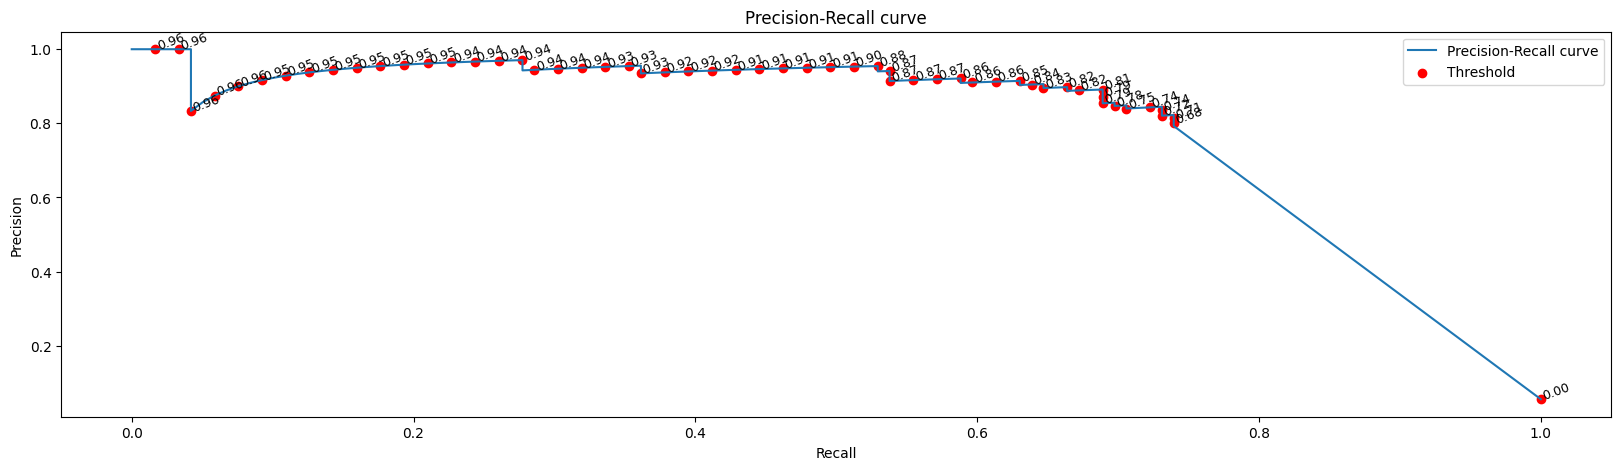

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")

for i in range(0, len(thresholds), 2):
    plt.text(recalls[i], precisions[i], f"{thresholds[i]:.2f}", fontsize=9, rotation=20)
    plt.scatter(recalls[i], precisions[i], color='red', label='Threshold', linewidths=1)

plt.legend(["Precision-Recall curve", "Threshold"])
plt.show()

In [30]:
iou_thresholds = np.linspace(0, 1, 20)
maps, precisions, recalls, prediction_thresholds = [], [], [], []
for thr in iou_thresholds:
    matching_dict, phantom_preds_dict, missed_gt_dict = {}, {}, {}
    for scene in DATA:
        gt_objects = DATA[scene]["gt"]
        pred_objects = DATA[scene]["pred"]
        matching_dict[scene], phantom_preds_dict[scene], missed_gt_dict[scene] = get_matches(gt_objects, pred_objects, thr)
    matching, phantom_preds, missed_gt = [], [], []
    for scene in DATA:
        matching.extend(matching_dict[scene])
        phantom_preds.extend(phantom_preds_dict[scene])
        missed_gt.extend(missed_gt_dict[scene])
    
    mean_ap, prec, rec, pred_thr = MAP(matching, phantom_preds, missed_gt, label2idx)
    maps.append(mean_ap)
    precisions.append(prec)
    recalls.append(rec)
    prediction_thresholds.append(pred_thr)
    


/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found

In [31]:
for i, thr in enumerate(iou_thresholds):
    print(f"MaP@{thr:.2f}: {maps[i]:.3f}")

MaP@0.00: 0.729
MaP@0.05: 0.622
MaP@0.11: 0.602
MaP@0.16: 0.559
MaP@0.21: 0.545
MaP@0.26: 0.504
MaP@0.32: 0.464
MaP@0.37: 0.450
MaP@0.42: 0.418
MaP@0.47: 0.388
MaP@0.53: 0.367
MaP@0.58: 0.354
MaP@0.63: 0.336
MaP@0.68: 0.309
MaP@0.74: 0.307
MaP@0.79: 0.307
MaP@0.84: 0.307
MaP@0.89: 0.309
MaP@0.95: 0.309
MaP@1.00: 0.309


In [32]:
MaP@0.00: 0.713
MaP@0.05: 0.645
MaP@0.11: 0.601
MaP@0.16: 0.574
MaP@0.21: 0.537
MaP@0.26: 0.480
MaP@0.32: 0.456
MaP@0.37: 0.440
MaP@0.42: 0.422
MaP@0.47: 0.385
MaP@0.53: 0.371
MaP@0.58: 0.356
MaP@0.63: 0.338
MaP@0.68: 0.319
MaP@0.74: 0.312
MaP@0.79: 0.307
MaP@0.84: 0.307
MaP@0.89: 0.309
MaP@0.95: 0.309
MaP@1.00: 0.309

SyntaxError: illegal target for annotation (1949578210.py, line 1)

In [ ]:
MaP@0.00: 0.717
MaP@0.05: 0.621
MaP@0.11: 0.604
MaP@0.16: 0.590
MaP@0.21: 0.543
MaP@0.26: 0.496
MaP@0.32: 0.458
MaP@0.37: 0.403
MaP@0.42: 0.367
MaP@0.47: 0.357
MaP@0.53: 0.335
MaP@0.58: 0.320
MaP@0.63: 0.318
MaP@0.68: 0.309
MaP@0.74: 0.306
MaP@0.79: 0.312
MaP@0.84: 0.312
MaP@0.89: 0.312
MaP@0.95: 0.312
MaP@1.00: 0.312

SyntaxError: illegal target for annotation (258279050.py, line 1)